In [3]:
import numpy as np

data = np.loadtxt("options_data.csv", dtype=str, delimiter=',', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 12))
print(data[0])


['date' 'exdate' 'cp_flag' 'strike_price' 'best_bid' 'best_offer' 'volume'
 'open_interest' 'impl_volatility' 'issuer']


In [4]:
from datetime import datetime

# create a sorted list of all dates in the option data
dates = set()
for option in data:
    if option[0] not in dates:
        if option[0] != 'date':
            dates.add(option[0])
            dates.add(option[1])
date_list = []
for date in dates:
    date_list.append(date)
    
date_list = (sorted(date_list, key=lambda x: datetime.strptime(x, '%Y-%m-%d')) )


In [5]:
duke_options = []

for option in data:
    # skip options with no IV or volume
#     if option[8] == '' or option[6] == '0':
    if option[6] == '0':
        continue
    if option[-1] == 'DUKE ENERGY CORP.':
        duke_options.append(option.tolist())
    elif option[-1] == 'PEPSICO INC':
        pepsi_options.append(option.tolist())
    elif option[-1] == 'EXXON MOBIL CORP.':
        exxon_options.append(option.tolist())
    elif option[-1] == 'VERIZON COMMUNICATIONS INC':
        verizon_options.append(option.tolist())

In [6]:
print(len(duke_options))
print(len(pepsi_options))
print(len(exxon_options))
print(len(verizon_options))

16486


In [7]:
# make dictionaries with keys of the following form:
# (expiration date, 'C'/'P', strike*1000)
def make_option_dict(options):
    option_dict = {}
    for option in duke_options:
#         option[0] = date_list.index(option[0])
#         option[1] = date_list.index(option[1])
        key = (option[1], option[2], int(option[3]))
        if key in option_dict:
            option_dict[key].append(option)
        else:
            option_dict[key] = [option]
    for key in option_dict.keys():
        option_dict[key] = sorted(option_dict[key], key=lambda x: datetime.strptime(x[0], '%Y-%m-%d'))
    return option_dict

In [8]:
duke_dict = make_option_dict(duke_options)
pepsi_dict = make_option_dict(pepsi_options)
exxon_dict = make_option_dict(exxon_options)
verizon_dict = make_option_dict(verizon_options)

Text(0, 0.5, 'Implied Volatility')

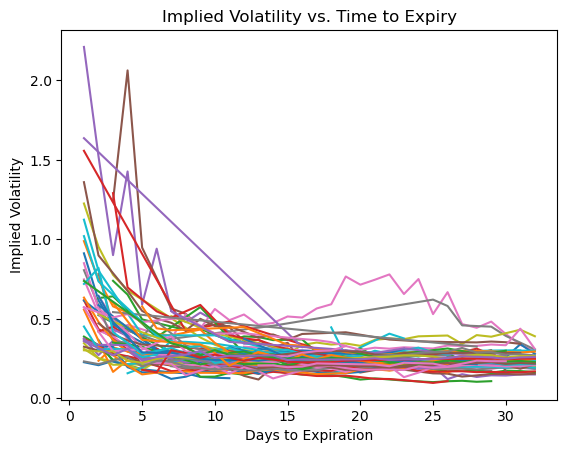

In [296]:
import matplotlib.pyplot as plt
i = 0
for key in duke_dict.keys():
    exp, cp, strike = key
    if strike != 95000:
        continue
    opt = duke_dict[key]
    ivs = []
    dates = []
    for day in opt:
#     day = opt[0]
        if day[8] != '':
            ivs.append( float(day[8]) )
            dates.append(np.busday_count(day[0], day[1]) )
    plt.plot(dates, ivs)
    i += 1
plt.title("Implied Volatility vs. Time to Expiry")
plt.xlabel("Days to Expiration")
plt.ylabel("Implied Volatility")


In [251]:
import scipy

# From pset 3
# Calculate implied volatility of a call with Newton's method
def implied_vol_call(call_price, K, T, S, R, error):
    # initial guess of 0.4 for volatility
    vol = 0.4
    dv = error + 1
    # add counter to prevent infinite loops when not converging
    i = 0
    # use Newton's method to find the IV
    while abs(dv) > error and i < 5000:
        d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
        d2 = d1 - vol*(T**0.5)
        price_error = S * scipy.stats.norm.cdf(d1) - K * np.exp(-R * T) * scipy.stats.norm.cdf(d2) - call_price
        vega = S * ( (T/(2*np.pi) )**0.5 ) * np.exp(- (d1**2) / 2)
#         if abs(vega) < 1e-10:
#             vega = 1e-10
        dv = price_error / vega
        vol = vol - dv
        i += 1
    return vol

# find implied volatility of a put
def implied_vol_put(put_price, K, T, S, R, error):
    # initial guess of 0.4 for volatility
    vol = 0.4
    dv = error + 1
    # add counter to prevent infinite loops when not converging
    i = 0
    # use Newton's method to find the IV
    while abs(dv) > error and i < 5000:
        d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
        d2 = d1 - vol*(T**0.5)
        price_error = K * np.exp(-R * T) * scipy.stats.norm.cdf(-d2) - S * scipy.stats.norm.cdf(-d1) - put_price
        vega = S * ( (T/(2*np.pi) )**0.5 ) * np.exp(- (d1**2) / 2)
#         if abs(vega) < 1e-10:
#             break
        dv = price_error / vega
        vol = vol - dv
        i += 1
    return vol

In [252]:
def get_options_by_exp(exp_date, option_dict):
    options = []
    for key in option_dict.keys():
        exp, cp, strike = key
        if exp == exp_date:
            options.append(option_dict[key])
    return options

In [262]:
# ['date' 'exdate' 'cp_flag' 'strike_price' 'best_bid' 'best_offer' 'volume'
# 'open_interest' 'impl_volatility' 'issuer']
# implied_vol(call_price, K, T, S, R, error)

def get_smiles(expire_date, curr_date, S, T, R, option_dict):
    curr_options = get_options_by_exp(expire_date, option_dict)
    put_smile = []
    call_smile = []
    # smiles for 05/12/2020 (29 business days from exp, R=1.57) and 05/11/2020 (28 business days from exp, R=1.58)
    # pre price: 61.47, ex price: 60.48
    for opt in curr_options:
        for day in opt:
            if day[0] == curr_date:
                if day[2] == 'C':
                    # use mid prices
                    call_price = ( float(day[4]) + float(day[5]) ) / 2
                    if day[8] == '':
                        iv = implied_vol_call(call_price, float(day[3])/1000, T/252, S, R, 0.01)
                    else:
#                         iv = float(day[8])
                        iv = implied_vol_call(call_price, float(day[3])/1000, T/252, S, R, 0.01)
                    call_smile.append([float(day[3])/1000, iv])
                elif day[2] == 'P':
                    put_price = ( float(day[4]) + float(day[5]) ) / 2
                    if day[8] == '':
                        iv = implied_vol_put(put_price, float(day[3])/1000, T/252, S, R, 0.01)
                    else:
#                         iv = float(day[8])
                        iv = implied_vol_put(put_price, float(day[3])/1000, T/252, S, R, 0.01)
                    put_smile.append([float(day[3])/1000, iv])
                

    call_smile = sorted(call_smile, key=lambda x: x[0])
    call_strikes = []
    call_ivs = []
    for call in call_smile:
        if call[0] > S:
            call_strikes.append(call[0])
            call_ivs.append(call[1])
        
    put_smile = sorted(put_smile, key=lambda x: x[0])
    put_strikes = []
    put_ivs = []
    for put in put_smile:
        if put[0] < S:
            put_strikes.append(put[0])
            put_ivs.append(put[1])
    strikes = put_strikes + call_strikes
    ivs = put_ivs + call_ivs
    return strikes, ivs
#     return call_strikes, call_ivs, put_strikes, put_ivs
        
        
# pre_cs, pre_civ, pre_ps, pre_piv = get_smiles("2020-03-20", '2020-02-12', 97.92, 26, 0.0158, duke_dict)
# ex_cs, ex_civ, ex_ps, ex_piv = get_smiles("2020-03-20", '2020-02-13', 97.81, 25, 0.0158, duke_dict)
# plt.plot(pre_cs, pre_civ, label="pre call")
# plt.plot(pre_ps, pre_piv, label="pre put")
# plt.plot(ex_cs, ex_civ, label="ex call")
# plt.plot(ex_ps, ex_piv, label="ex put")

# plt.legend()


#     return call_strikes, call_ivs, put_strikes, put_ivs

In [255]:
def near_exp(date, option_dict):
    for key in option_dict.keys():
        exp_date , __, __ = key
        if np.busday_count(date, exp_date) < 45 and np.busday_count(date, exp_date) > 10:
            return exp_date

C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  dv = price_error / vega
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )


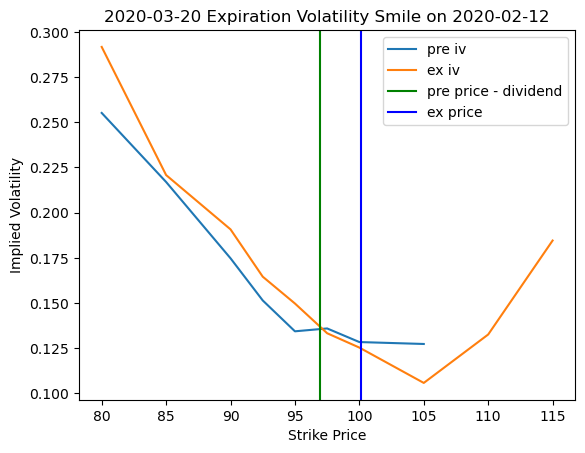

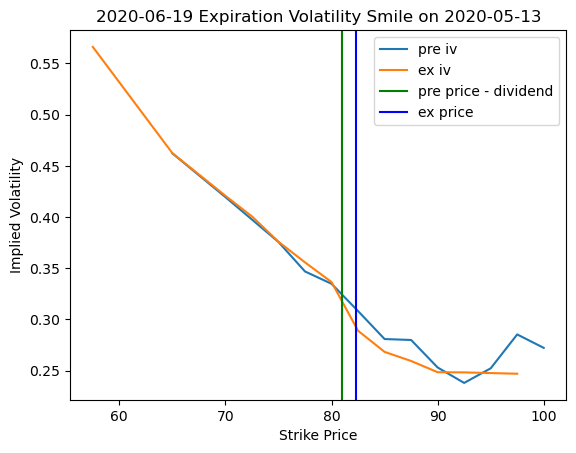

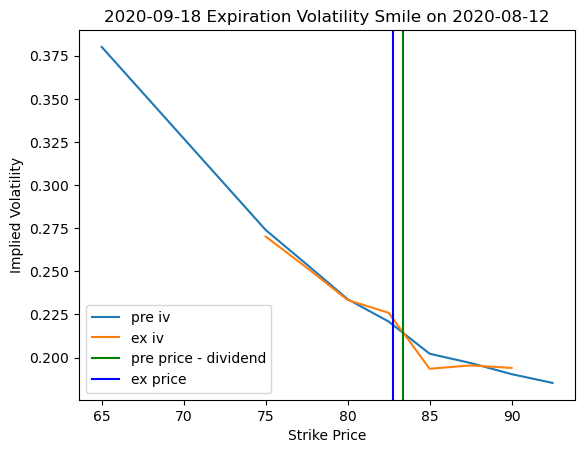

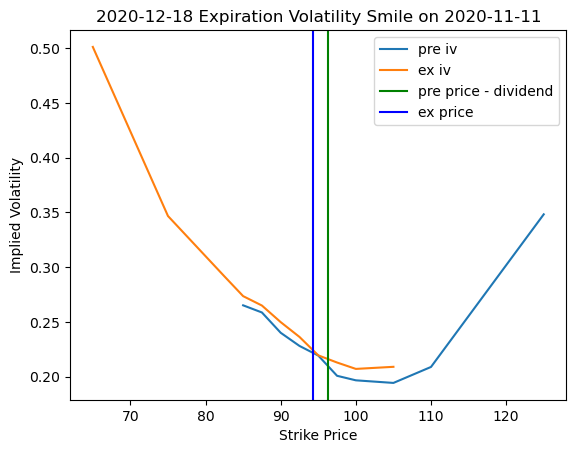

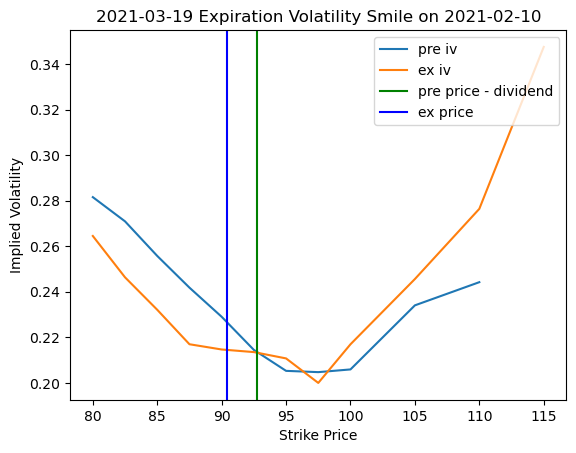

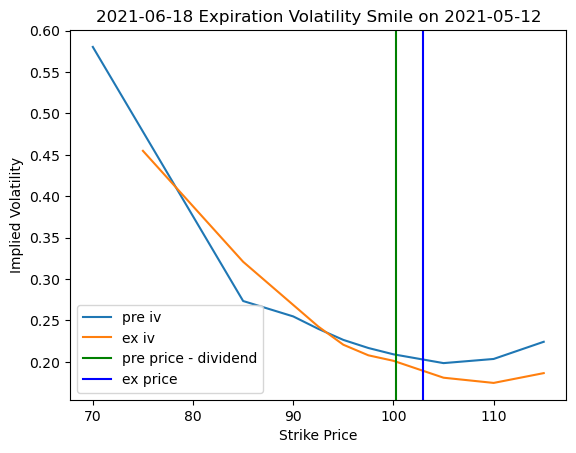

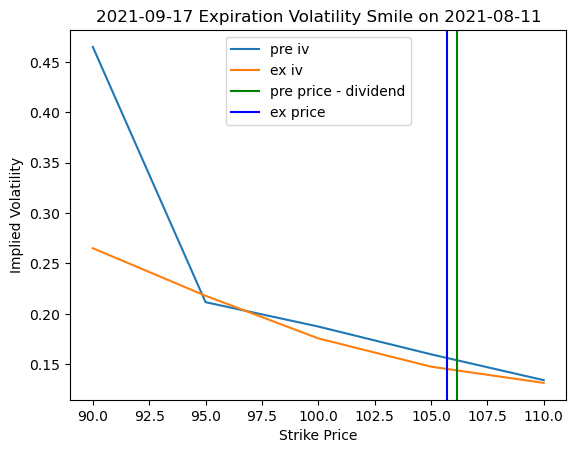

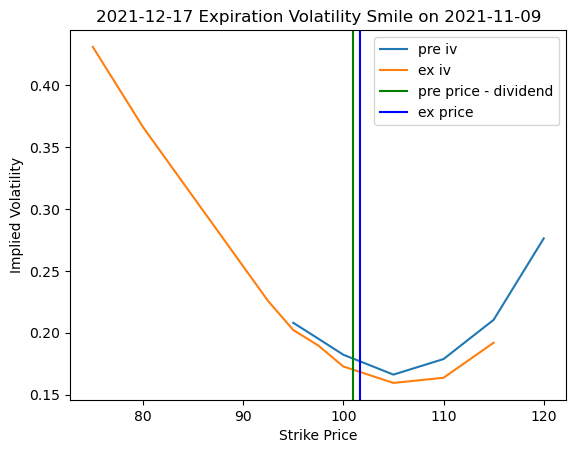

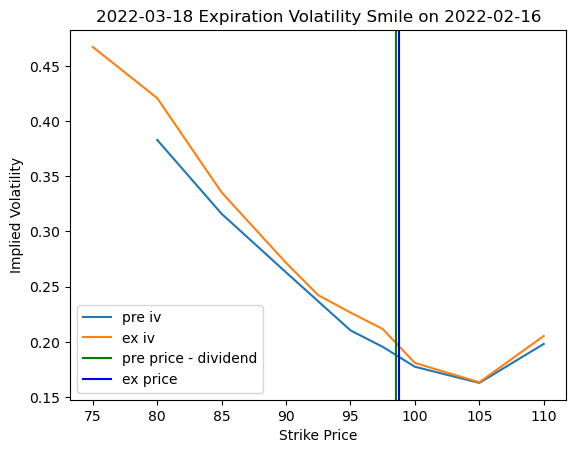

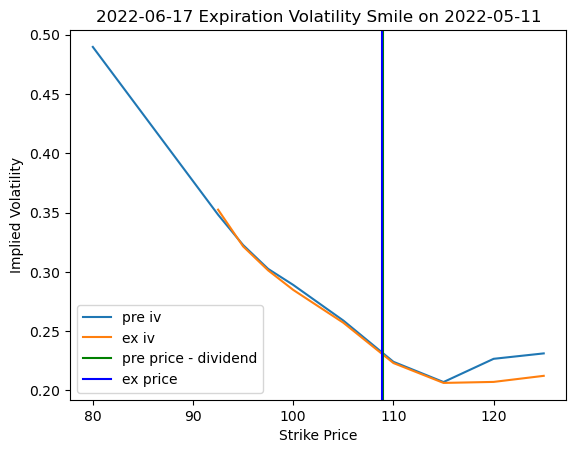

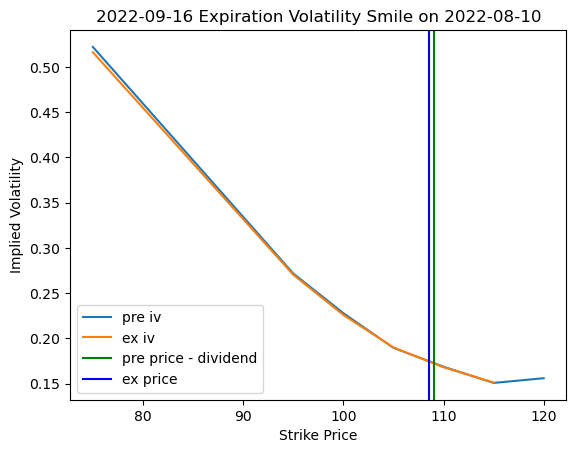

<Figure size 640x480 with 0 Axes>

In [298]:
dates_prices = [
    ('2020-02-13', '2020-02-12', 100.11, 97.92-0.945),
    ('2020-05-14', '2020-05-13', 82.30, 81.89-0.945),
    ('2020-08-13', '2020-08-12', 82.74, 84.32-0.965),
    ('2020-11-12', '2020-11-11', 94.25, 97.31-0.965),
    ('2021-02-11', '2021-02-10', 90.42, 93.70-0.965),
    ('2021-05-13', '2021-05-12', 103.00, 101.22-0.965),
    ('2021-08-12', '2021-08-11', 105.69, 107.14-0.985),
    ('2021-11-10', '2021-11-09', 101.62, 101.96-0.985),
    ('2022-02-17', '2022-02-16', 98.73, 99.51-0.985),
    ('2022-05-12', '2022-05-11', 108.85, 109.91-0.985),
    ('2022-08-11', '2022-08-10', 108.51, 110.06-1.005)
    
]


for div in dates_prices:
    ex_date, pre_date, ex_price, pre_price = div
    exp_date = near_exp(ex_date, duke_dict)
    T = np.busday_count(pre_date, exp_date)
#     pre_cs, pre_civ, pre_ps, pre_piv = get_smiles(exp_date, pre_date, pre_price, T, 0.0158, duke_dict)
#     ex_cs, ex_civ, ex_ps, ex_piv = get_smiles(exp_date, ex_date, ex_price, T-1, 0.0158, duke_dict)
#     plt.plot(pre_cs, pre_civ, label="pre call")
#     plt.plot(pre_ps, pre_piv, label="pre put")
#     plt.plot(ex_cs, ex_civ, label="ex call")
#     plt.plot(ex_ps, ex_piv, label="ex put")

    pre_strike, pre_iv = get_smiles(exp_date, pre_date, pre_price, T, 0.0158, duke_dict)
    ex_strike, ex_iv = get_smiles(exp_date, ex_date, ex_price, T, 0.0158, duke_dict)
    plt.plot(pre_strike, pre_iv, label="pre iv")
    plt.plot(ex_strike, ex_iv, label="ex iv")
   
    plt.title(exp_date + " Expiration Volatility Smile on " + pre_date)
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    
    plt.axvline(x = pre_price, color="g", label="pre price - dividend")
    plt.axvline(x = ex_price, color="b", label="ex price")
    plt.legend()
    plt.figure()
    

# pre_cs, pre_civ, pre_ps, pre_piv = get_smiles("2020-06-19", '2020-05-13', 81.89, 26, 0.0158, duke_dict)
# ex_cs, ex_civ, ex_ps, ex_piv = get_smiles("2020-06-19", '2020-05-14', 80.00, 25, 0.0158, duke_dict)
# plt.plot(pre_cs, pre_civ, label="pre call")
# plt.plot(pre_ps, pre_piv, label="pre put")
# plt.plot(ex_cs, ex_civ, label="ex call")
# plt.plot(ex_ps, ex_piv, label="ex put")
# plt.legend()

In [271]:
# black scholes prices. options include no more dividends until expiry
def bs_price_call(F, K, R, vol, T):
    d1 = ( np.log(F) - np.log(K) ) / (vol * (T**0.5) ) + (vol * (T ** 0.5) ) /2 
    d2 = d1 - vol*(T**0.5)
    price = np.exp(-R * T) * ( F * scipy.stats.norm.cdf(d1) - K *  scipy.stats.norm.cdf(d2) )
    return price

def bs_price_put(F, K, R, vol, T):
    call = bs_price_call(F, K, R, vol, T)
    price = call - np.exp(-R * T) * (F - K)
    return price

In [1]:
# Example verifying that option retains same value before and after dividend
S = 50
E = 50
R = 0.05
T = 30
vol = 0.4
D = 10
Td = 15


F = np.exp(Td*R) * (S*np.exp(Td * R) - D)
lmbda = 1 + D / (S * np.exp(Td * R) - D)
print(F, lmbda)
print(S * np.exp(R * T))
print(bs_price_call(S * np.exp(R * T), E, R, vol, T))
print(lmbda * bs_price_call(F, E/lmbda, R, vol, T))

NameError: name 'np' is not defined

C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  dv = price_error / vega
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )
C:\Users\wbalk\AppData\Local\Temp\ipykernel_20032\1349565906.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S) - np.log(K) + (R + (vol**2)/2) * T) / ( vol * (T**0.5) )


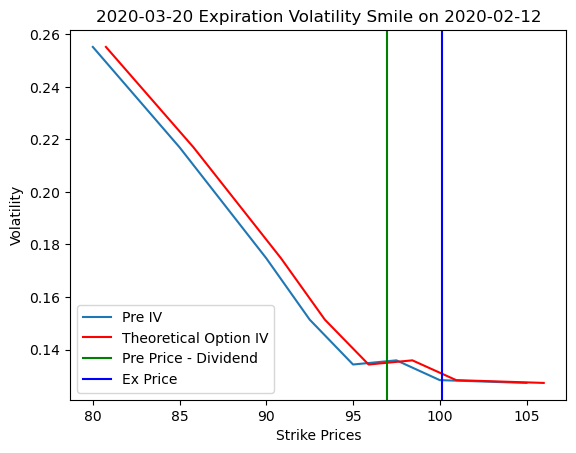

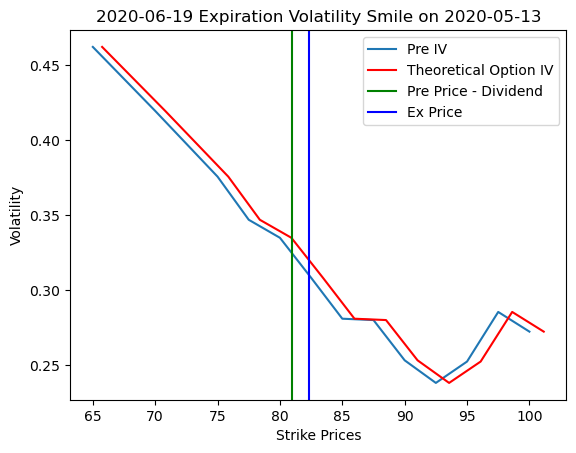

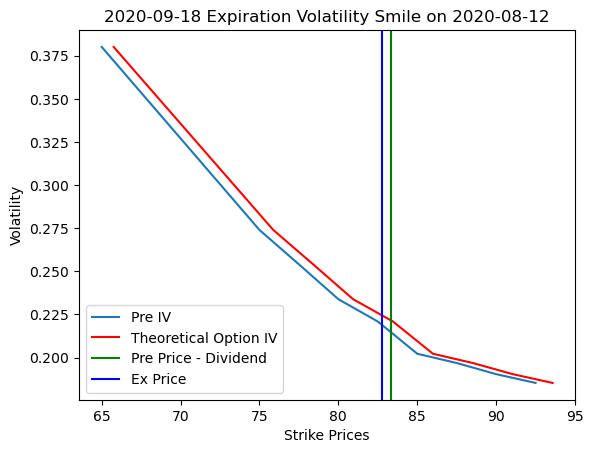

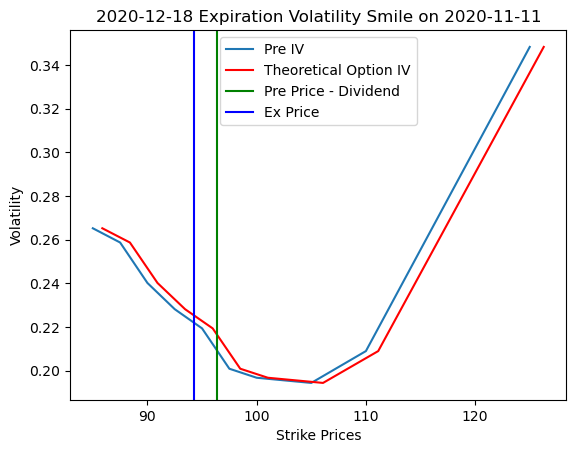

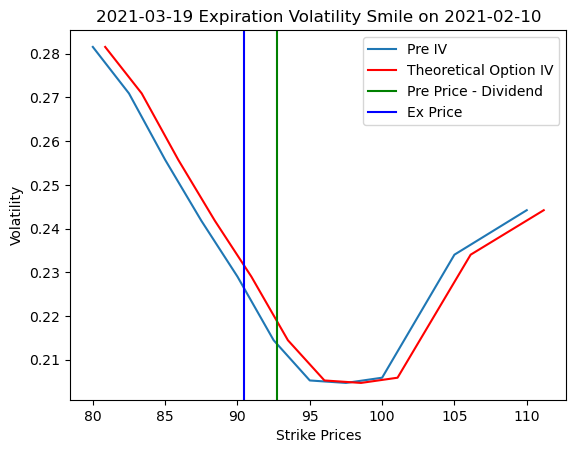

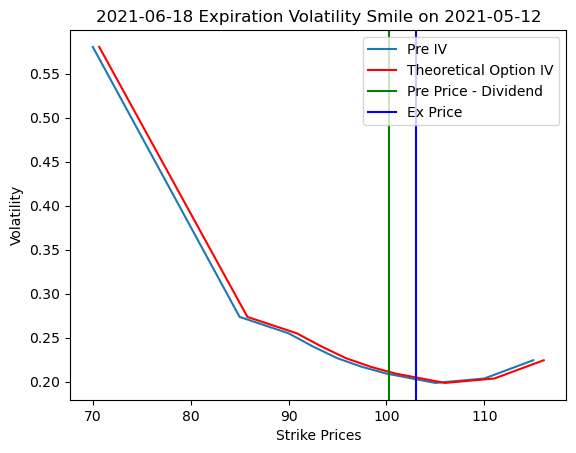

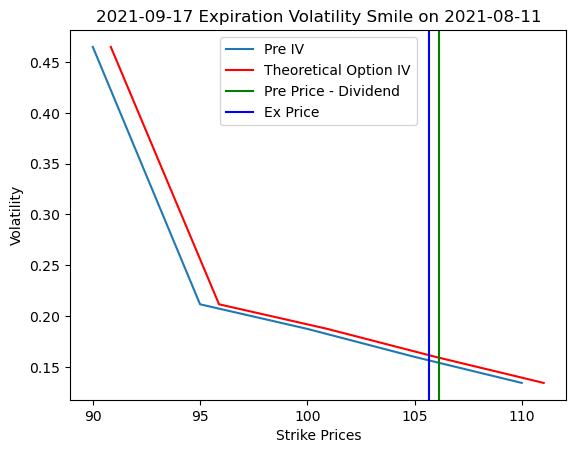

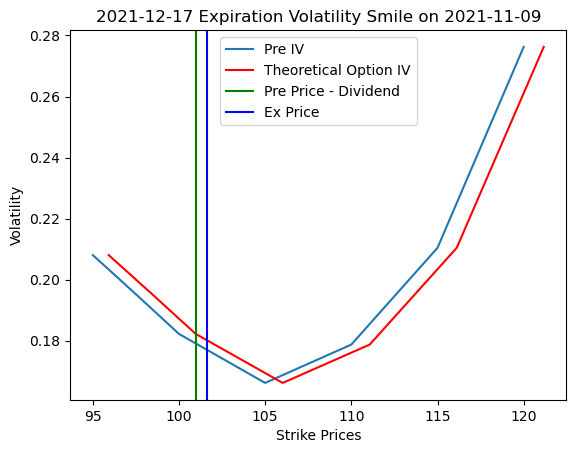

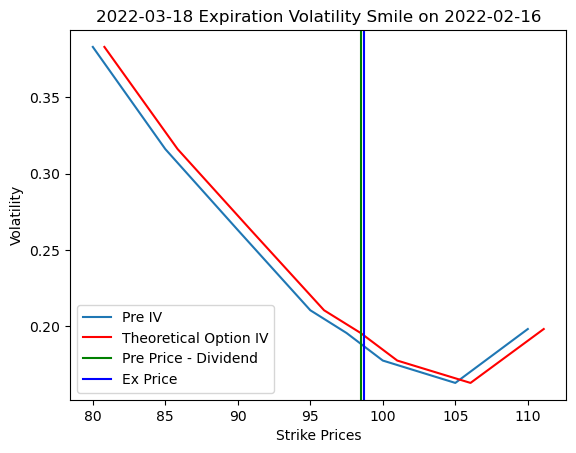

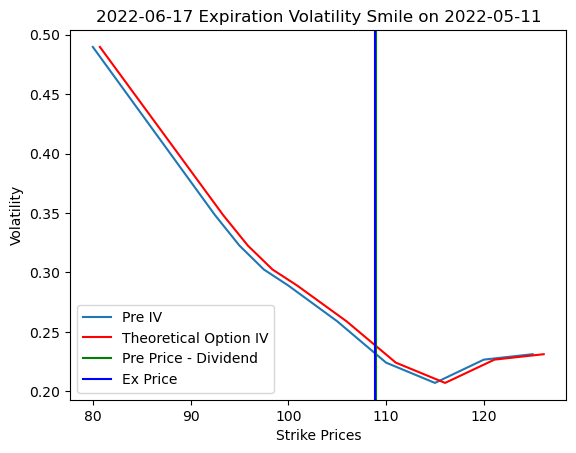

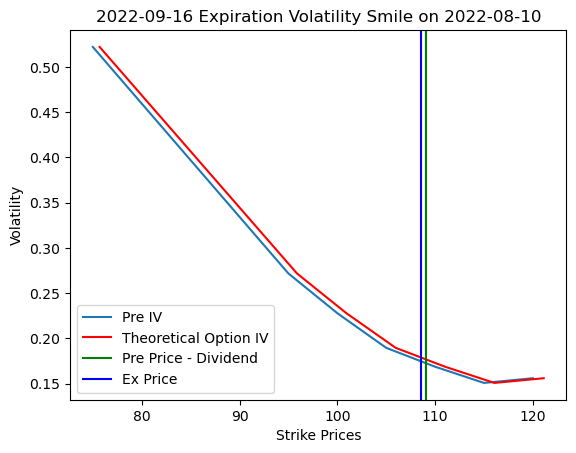

<Figure size 640x480 with 0 Axes>

In [303]:
# plot smiles again but include theoretical option's smiles
dates_prices = [
    ('2020-02-13', '2020-02-12', 100.11, 97.92, 0.945),
    ('2020-05-14', '2020-05-13', 82.30, 81.89, 0.945),
    ('2020-08-13', '2020-08-12', 82.74, 84.32, 0.965),
    ('2020-11-12', '2020-11-11', 94.25, 97.31, 0.965),
    ('2021-02-11', '2021-02-10', 90.42, 93.70, 0.965),
    ('2021-05-13', '2021-05-12', 103.00, 101.22, 0.965),
    ('2021-08-12', '2021-08-11', 105.69, 107.14, 0.985),
    ('2021-11-10', '2021-11-09', 101.62, 101.96, 0.985),
    ('2022-02-17', '2022-02-16', 98.73, 99.51, 0.985),
    ('2022-05-12', '2022-05-11', 108.85, 109.91, 0.985),
    ('2022-08-11', '2022-08-10', 108.51, 110.06, 1.005)
    
]

for div in dates_prices:
    ex_date, pre_date, ex_price, pre_price, div_amount = div
    exp_date = near_exp(ex_date, duke_dict)
    T = np.busday_count(pre_date, exp_date)
    
    pre_strike, pre_iv = get_smiles(exp_date, pre_date, pre_price - div_amount, T, 0.0158, duke_dict)
    ex_strike, ex_iv = get_smiles(exp_date, ex_date, ex_price, T, 0.0158, duke_dict)
    plt.plot(pre_strike, pre_iv, label="Pre IV")
#     plt.plot(ex_strike, ex_iv, label="ex iv")
    
    
    lmbda = 1 + ( div_amount / ex_price )
    
    pre_scaled_strike = []
    for strike in pre_strike:
        pre_scaled_strike.append(strike * lmbda)
    plt.plot(pre_scaled_strike, pre_iv, label="Theoretical Option IV", color="r")
   
    plt.title(exp_date + " Expiration Volatility Smile on " + pre_date)
    plt.xlabel("Strike Prices")
    plt.ylabel("Volatility")
    plt.axvline(x = pre_price-div_amount, color="g", label="Pre Price - Dividend")
    plt.axvline(x = ex_price, color="b", label="Ex Price")
    plt.legend()
    plt.figure()

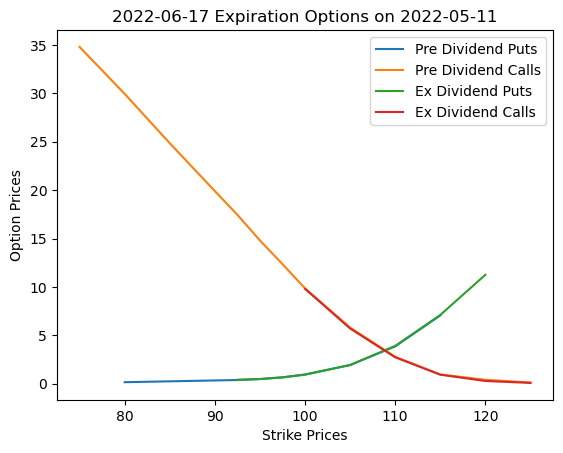

In [302]:
options = get_options_by_exp('2022-06-17', duke_dict)
# '2022-05-11' and '2022-05-12'
pre_puts = []
pre_calls = []
ex_puts = []
ex_calls = []
for option in options:
    for day in option:
        if day[0] == '2022-05-11':
            if day[2] == 'C':
                pre_calls.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
            elif day[2] == 'P':
                pre_puts.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
        if day[0] == '2022-05-12':
            if day[2] == 'C':
                ex_calls.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
            elif day[2] == 'P':
                ex_puts.append((float(day[3])/1000, (float(day[4]) + float(day[5]))/2))
                
pre_puts = sorted(pre_puts, key = lambda x: x[0])
pre_calls = sorted(pre_calls, key = lambda x: x[0])
ex_puts = sorted(ex_puts, key = lambda x: x[0])
ex_calls = sorted(ex_calls, key = lambda x: x[0])

pre_put_strikes, pre_put_prices = zip(*pre_puts)
pre_call_strikes, pre_call_prices = zip(*pre_calls)
ex_put_strikes, ex_put_prices = zip(*ex_puts)
ex_call_strikes, ex_call_prices = zip(*ex_calls)

plt.plot(pre_put_strikes, pre_put_prices, label="Pre Dividend Puts")
plt.plot(pre_call_strikes, pre_call_prices, label="Pre Dividend Calls")
plt.plot(ex_put_strikes, ex_put_prices, label="Ex Dividend Puts")
plt.plot(ex_call_strikes, ex_call_prices, label="Ex Dividend Calls")
plt.xlabel("Strike Prices")
plt.ylabel("Option Prices")
plt.title("2022-06-17 Expiration Options on 2022-05-11")
plt.legend()